<a href="https://colab.research.google.com/github/beepbeep63/CMPE-CISC351/blob/main/RQ1_Tenrec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Download and Mount
Based on the following code:
https://www.kaggle.com/code/astrung/recbole-lstm-sequential-for-recomendation-tutorial

In [1]:
!pip install polars

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 51.5 MB/s eta 0:00:00


In [2]:
!pip install recbole

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.9 MB/s eta 0:00:00


In [5]:
import tqdm
import polars as pl
import numpy as np
import pandas as pd
import seaborn as sns
import random
import os 
import h5py
import sys
import gc

from matplotlib import pyplot as plt
import pyarrow.parquet as pq

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. EDA and Preprocessing

(21626, 10)


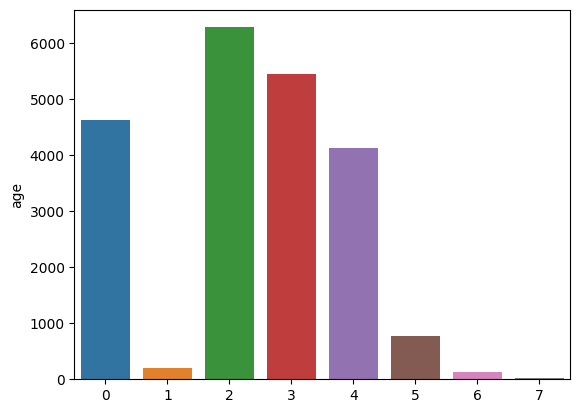

In [7]:
df = pd.read_csv('/content/drive/MyDrive/University/CMPE 351/sbr_data_1M.csv', nrows=1000000)

user_info = df.drop_duplicates(subset=["user_id"])
user_info.head()
print(user_info.shape)

sns.barplot(data=user_info, y=user_info['age'].value_counts(), x=[2, 3, 0, 4, 5, 1, 6, 7])

#df = df.sort_values(['user_id'])

df['timestamp'] = df.index

mapping = {'user_id':'user_id:token', 'item_id': 'item_id:token', 'timestamp':'timestamp:float'}
df = df.rename(columns=mapping)

df0 = df[df['age'] == 0]
df1 = df[df['age'] == 1]
df2 = df[df['age'] == 2]
df3 = df[df['age'] == 3]
df4 = df[df['age'] == 4]
df5 = df[df['age'] == 5]
df6 = df[df['age'] == 6]
df7 = df[df['age'] == 7]

In [8]:
df5.shape

(31172, 11)

In [9]:
data = df.drop(columns=['click', 'follow', 'like', 'share', 'video_category', 'gender', 'age', 'watching_times'])
print(data.shape)

data = data[~data.isnull()]
print(data.shape)

data.head()

(1000000, 3)
(1000000, 3)


,user_id:token,item_id:token,timestamp:float
0,1,1,0
1,1,2,1
2,1,3,2
3,1,80936,3
4,1,781,4


In [10]:
data.head()
data['user_id:token'].unique()

array([    1,     2,     3, ..., 21624, 21625, 21626])

In [11]:
!mkdir /content/data

data.to_csv('/content/data/data.inter', index=False, sep='\t')

In [12]:
print(data.head())
print(data.dtypes)
df_inter = pd.read_csv('/content/data/data.inter')
print(df_inter.head())

   user_id:token  item_id:token  timestamp:float
0              1              1                0
1              1              2                1
2              1              3                2
3              1          80936                3
4              1            781                4
user_id:token      int64
item_id:token      int64
timestamp:float    int64
dtype: object
  user_id:token\titem_id:token\ttimestamp:float
0                                       1\t1\t0
1                                       1\t2\t1
2                                       1\t3\t2
3                                   1\t80936\t3
4                                     1\t781\t4


# 3. Create dataset and train model with Recbole

Documentation: https://recbole.io/docs/user_guide/usage/use_modules.html

In [13]:
import logging
from logging import getLogger
from recbole.config import Config
from recbole.data import create_dataset, data_preparation
from recbole.model.sequential_recommender import BERT4Rec, GRU4Rec
from recbole.trainer import Trainer
from recbole.utils import init_seed, init_logger

from recbole.utils.case_study import full_sort_topk

In [14]:
MAX_ITEM = 20

parameter_dict = {
    'data_path': '/content/',
    'USER_ID_FIELD': 'user_id',
    'ITEM_ID_FIELD': 'item_id',
    'TIME_FIELD': 'timestamp',
    'user_inter_num_interval': "[5,Inf)",
    'item_inter_num_interval': "[5,Inf)",
    'load_col': {'inter': ['user_id', 'item_id', 'timestamp'], 'item': ['item_id', 'item_emb']},
    'train_neg_sample_args': None,
    'epochs': 10,
    'stopping_step':3,
    'eval_batch_size': 1024,
    #'train_batch_size': 1024,
    #'enable_amp':True,
    'MAX_ITEM_LIST_LENGTH': MAX_ITEM,
    'eval_args': {
        'split': {'RS': [9, 1, 0]},
        'group_by': 'user',
        'order': 'TO',
        'mode': 'full'},
    'shuffle': False,
    'lowest_val': {'item_id:token': 0}
}

config = Config(model='GRU4Rec', dataset='data', config_dict=parameter_dict)

# init random seed
init_seed(config['seed'], config['reproducibility'])

# logger initialization
init_logger(config)
logger = getLogger()

# Create handlers
c_handler = logging.StreamHandler()
c_handler.setLevel(logging.INFO)
logger.addHandler(c_handler)

# write config info into log
logger.info(config)

In [15]:
dataset = create_dataset(config)
logger.info(dataset)

In [16]:
# dataset splitting
train_data, valid_data, test_data = data_preparation(config, dataset)

In [17]:
# model loading and initialization
model = GRU4Rec(config, train_data.dataset).to(config['device'])
logger.info(model)

# trainer loading and initialization
trainer = Trainer(config, model)

# model training
best_valid_score, best_valid_result = trainer.fit(train_data, valid_data)
#best_valid_score, best_valid_result = trainer.fit(train_data)

In [18]:
print(best_valid_score)
print(best_valid_result)
import gc
del trainer, train_data, valid_data, test_data

0.013
OrderedDict([('recall@10', 0.0392), ('mrr@10', 0.013), ('ndcg@10', 0.019), ('hit@10', 0.0392), ('precision@10', 0.0039)])


In [19]:
gc.collect()

0